# 1. Section: Image Recognition with AI Models

In this section, we’ll demonstrate how to send images to multimodal AI models like Claude (Anthropic) and GPT-4o (OpenAI) through their respective APIs.

We'll explore how these models "see" and interpret images by submitting visual data in a prompt and retrieving structured or descriptive feedback.

This is a practical example of multimodal prompting, where both text and images are processed by a single model to generate meaningful output.

## 1. Install OpenAI and Anthropic client libraries

In [1]:
!pip install --upgrade openai anthropic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.4/948.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.108.0
    Uninstalling openai-1.108.0:
      Successfully uninstalled openai-1.108.0


## 2. Upload Image(s)

This cell allows you to upload one or more image files from your local machine to the Colab environment. These images will be used in the next steps for processing and sending to AI models.

Saving Cat-Cat_Guide-Two_cats_sleeping_together_one_using_the_other_as_a_pillow.webp to Cat-Cat_Guide-Two_cats_sleeping_together_one_using_the_other_as_a_pillow.webp
✅ Uploaded: Cat-Cat_Guide-Two_cats_sleeping_together_one_using_the_other_as_a_pillow.webp | Size: (850, 600) | Mode: RGB


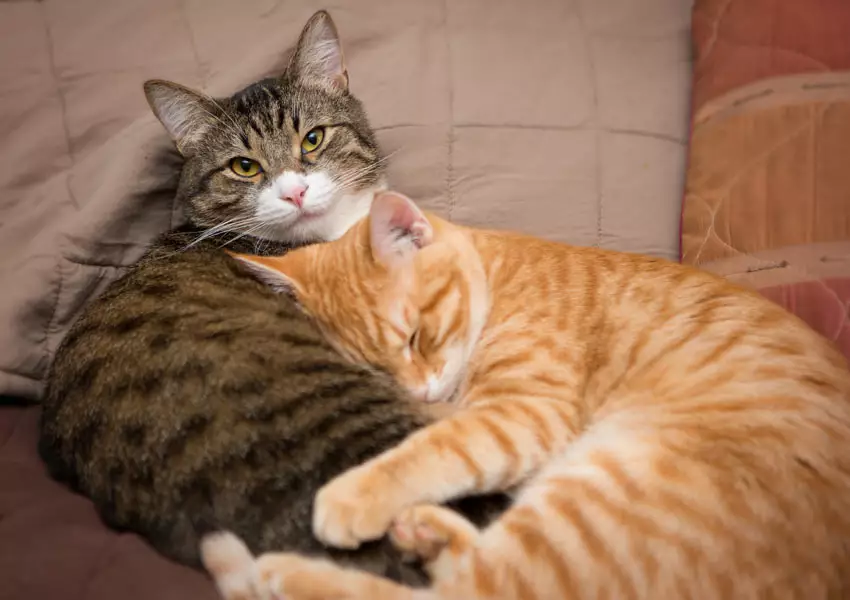

In [2]:
# 📄 Upload images from local machine

# We use Google Colab's built-in file upload utility
from google.colab import files
from PIL import Image
from io import BytesIO
import IPython.display as display

# Upload one or more image files (supports formats like PNG, JPG, etc.)
uploaded_files = files.upload()

# Display uploaded images and store them as PIL Image objects
images = []

for filename, file_data in uploaded_files.items():
    image = Image.open(BytesIO(file_data))
    images.append(image)
    print(f"✅ Uploaded: {filename} | Size: {image.size} | Mode: {image.mode}")
    display.display(image)


## 3. Convert Image(s) to Base64

This cell defines a helper function that converts a PIL image to a Base64-encoded string. This format is required by most AI APIs when sending image content directly in the request.

In [3]:
# 📦 Utility to convert images to Base64 strings for API input
import base64

def image_to_base64(image: Image.Image, format: str = "PNG") -> str:
    """
    Converts a PIL Image object to a base64-encoded string.

    Args:
        image (PIL.Image.Image): The input image.
        format (str): Image format to use for encoding (default is PNG).

    Returns:
        str: Base64-encoded string of the image.
    """
    buffered = BytesIO()
    image.save(buffered, format=format)
    img_bytes = buffered.getvalue()
    encoded = base64.b64encode(img_bytes).decode("utf-8")
    return encoded

# 🧪 Example: Convert all uploaded images
base64_images = [image_to_base64(img) for img in images]

print(f"✅ Converted {len(base64_images)} image(s) to base64 format.")


✅ Converted 1 image(s) to base64 format.


## 4. Send Multiple Images to GPT‑4o-mini for Description

This cell prepares a prompt containing multiple base64-encoded images and sends it to OpenAI’s GPT‑4o-mini via the chat API. The model will analyze all images and return a description for each.

In [4]:
# Used to securely store your API key
from google.colab import userdata
import os

# Set your OpenAI API key in Colab's secrets manager under the name 'OPENAI_API_KEY'
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

print("✅ OpenAI API key set from Colab userdata.")

✅ OpenAI API key set from Colab userdata.


In [5]:
# 🧠 Use OpenAI Responses API to describe multiple images

import base64
from openai import OpenAI

client = OpenAI()

# Prepare input content for the response
input_payload = [
    {
        "role": "user",
        "content": [
            {"type": "input_text", "text": "Please describe all of these images in detail:"},
            *[
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{b64}",
                    "detail": "high"  # Can be "low", "high", or omitted for "auto"
                }
                for b64 in base64_images
            ]
        ]
    }
]

# Send the request to the Responses API
response = client.responses.create(
    model="gpt-4o-mini",
    input=input_payload,
)

# Show the result
print("📝 GPT-4o-mini Response:")
print(response.output_text)


📝 GPT-4o-mini Response:
The image features two cats lying together in a cozy manner. 

1. **Cat Colors and Patterns**:
   - The first cat has a gray and black striped coat, with distinct markings that give it a tabby appearance. Its fur appears soft and fluffy.
   - The second cat is a vibrant orange with lighter stripes, suggesting it’s also a tabby.

2. **Posture and Interaction**:
   - The gray tabby is resting with its head slightly raised, looking directly at the camera. Its posture conveys a sense of alertness mixed with relaxation.
   - The orange tabby is nestled close to the gray cat, with its eyes closed, suggesting it’s asleep or deeply relaxed. Its body curves around the other cat, creating a warm, intimate connection.

3. **Background and Setting**:
   - The cats are lying on a quilted fabric surface—likely a blanket or sofa—that has muted colors, providing a simple backdrop that emphasizes their fur's contrast.
   - The overall atmosphere is calm and cozy, highlighting th

## 5. Analyze Multiple Images Using Claude API (Claude 4 Sonnet)

This cell sends multiple base64 images to Claude via the Anthropic API, asking the model to describe them. Images are passed as a list of data URIs inside a user message.

In [6]:
# Used to securely store your API key
from google.colab import userdata
import os

# Set your Anthropic API key in Colab's secrets manager under the name 'ANTHROPIC_API_KEY'
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

print("✅ Anthropic API key set from Colab userdata.")

✅ Anthropic API key set from Colab userdata.


In [7]:
# 🧠 Send multiple images to Claude (Anthropic) for description

import anthropic
import base64

client = anthropic.Anthropic()

# Build image blocks
image_blocks = [
    {
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": "image/png",  # Assuming PNG; change if needed
            "data": b64
        }
    }
    for b64 in base64_images
]

# Compose the full prompt with images + text
response = client.messages.create(
    model="claude-sonnet-4-20250514",
    max_tokens=1000,
    temperature=0.5,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Give me a list with coordinates of all the ears of the cats in the image"},
                *image_blocks
            ]
        }
    ]
)

# Print Claude's response
print("📝 Claude Response:")
print(response.content[0].text)


📝 Claude Response:
Looking at this image, I can identify two cats and their ear locations:

**Cat 1 (Tabby cat in background):**
- Left ear: approximately (175, 85)
- Right ear: approximately (265, 70)

**Cat 2 (Orange/ginger cat in foreground):**
- Left ear: approximately (480, 280)
- Right ear: approximately (520, 270)

Note: The orange cat's head is mostly turned away/buried, so the ear coordinates are approximate based on the visible portions. The tabby cat's ears are more clearly visible and the coordinates should be more accurate. Coordinates are given as (x, y) pixels from the top-left corner of the image.


# 2. Image Generation and Editing with Nano Banana

In this section, we’ll explore Nano Banana—Google’s latest state-of-the-art image generation and editing model (also known as Gemini 2.5 Flash Image). You’ll see how it can generate images from text, edit existing visuals with natural-language instructions, blend multiple images, maintain character consistency across edits, and perform iterative refinements—all while preserving the original context and coherence. This is generative AI at its most nimble and intuitive.

## 1. Setup for Nano Banana (Gemini Image API)


This cell installs the required SDK to access Google’s Gemini image generation/editing capabilities, including the new Nano Banana model. We’ll use the official google.generativeai library to interact with the Gemini API.

## 1. Install & Initialize Gemini 2.5 Flash Image
This cell installs the Google Gen AI Python SDK and initializes the Gemini client using the correct model for image generation and editing: gemini-2.5-flash-image-preview.

In [8]:
# 📦 Install the official Google Generative AI SDK (latest version)
!pip install -U google-generativeai


In [9]:
# 👉 Set up your Gemini API key and initialize the correct model
import os
import google.generativeai as genai
from google.colab import userdata # Import userdata to get API key

# Securely set your API key for Gemini from Colab's secrets
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the proper Gemini model: Gemini 2.5 Flash Image (nano-banana)
# Use GenerativeModel directly
model = genai.GenerativeModel(model_name="gemini-2.5-flash-image-preview")

print("✅ Initialized Gemini 2.5 Flash Image (Nano Banana) model successfully.")

✅ Initialized Gemini 2.5 Flash Image (Nano Banana) model successfully.


## 2. Generating a 'Cyber Tiger' Image

In [10]:
"""Generate a 'cyber tiger' with Gemini 2.5 Flash Image (preview) via google.generativeai.
- Uses GenerativeModel(...).generate_content(...)
- Demonstrates model properties (temperature, seed, candidate_count)
- Compact image extraction (handles bytes/base64)
"""
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display
import google.generativeai as genai

# If not already configured earlier, uncomment and set your key:
# genai.configure(api_key="YOUR_GOOGLE_API_KEY")

# Initialize the correct model (no Client(), no .models.generate_content)

prompt = ("Create a high-resolution futuristic cyber tiger with glowing neon circuits, "
          "mechanical armor, and a sci-fi night city backdrop. Photorealistic, cinematic lighting.")

res = model.generate_content(
    prompt,
    generation_config=genai.types.GenerationConfig(
        temperature=0.7,     # creativity
        candidate_count=1,   # number of images

    ),
)

# --- Compact image extraction ---
parts = getattr(res, "parts", None) or res.candidates[0].content.parts
imgs = []
for p in parts:
    inline = getattr(p, "inline_data", None)
    if not inline or not getattr(inline, "mime_type", "").startswith("image/"):
        continue
    data = inline.data if isinstance(inline.data, (bytes, bytearray)) else base64.b64decode(inline.data)
    imgs.append(Image.open(BytesIO(data)))

if not imgs:
    print("No image returned — ensure model access and try a simpler prompt.")
else:
    for i, img in enumerate(imgs, 1):
        display(img)
        img.save(f"cyber_tiger_{i}.png")
        print(f"saved: cyber_tiger_{i}.png")


TooManyRequests: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-image-preview:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0
Please retry in 52.069625697s.

## 3. Edit Image — Blue Lights & Warzone

Edits the previously saved cyber_tiger_1.png: switch lighting to electric blue and place the tiger in a gritty warzone (smoke, debris, sparks). Keeps the subject consistent.

In [ ]:
"""Edit the saved cyber tiger image:
- Make all glowing elements electric blue
- Place the scene in a gritty warzone (smoke, debris, sparks, firelight)
- Preserve the tiger's identity and main pose
Requires: model = genai.GenerativeModel("gemini-2.5-flash-image-preview")
"""
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display
import google.generativeai as genai

# Upload the previously generated image
src_path = "/content/5.png"  # adjust if your filename differs

img_file = genai.upload_file(src_path)

# Clear editing instruction (keep subject consistent)
instruction = (
    "Make the photo from the 1944 year, and he is on the front lines participating in world war 2"
)

# Call the image model with text + image parts
res = model.generate_content(
    [instruction, img_file],
    generation_config=genai.types.GenerationConfig(
        temperature=0.5,      # more faithful edits
        candidate_count=3
    ),
)

# --- Compact image extraction (handles bytes/base64) ---
def _decode(b):
    return b if isinstance(b, (bytes, bytearray)) else base64.b64decode(b)

parts = getattr(res, "parts", None) or res.candidates[0].content.parts
out_imgs = []
for p in parts:
    inline = getattr(p, "inline_data", None)
    if not inline or not getattr(inline, "mime_type", "").startswith("image/"):
        continue
    out_imgs.append(Image.open(BytesIO(_decode(inline.data))))

if not out_imgs:
    print("No edited image returned — verify model access or try a simpler instruction.")
else:
    for i, img in enumerate(out_imgs, 1):
        fname = f"cyber_tiger_edit_{i}.png"
        display(img)
        img.save(fname)
        print(f"💾 saved: {fname}")


## 1. ElevenLabs — TTS, Streaming & Voice Tools
We’ll use the ElevenLabs Python SDK to: (1) list available voices, (2) generate speech from text, and (3) run a basic speech-to-speech (voice changer) demo. Streaming and SFX are linked for reference.

### 1. Install the SDK
Installs the official ElevenLabs Python client.

In [12]:
# Install the official ElevenLabs SDK
!pip install -U elevenlabs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/955.6 kB 15.6 MB/s eta 0:00:00


### 2. Configure API Key & Client

In [13]:
# Import necessary libraries
import os
from elevenlabs.client import ElevenLabs
from google.colab import userdata

# Set your ElevenLabs API key in Colab's secrets manager under the name 'ELEVENLABS_API_KEY'
# Prefer env var for security; fallback to manual paste for quick demos
API_KEY = userdata.get("ELEVENLABS_API_KEY")
client = ElevenLabs(api_key=API_KEY)

print("✅ ElevenLabs client initialized.")

✅ ElevenLabs client initialized.


### 3. List Your Voices (name → voice_id)
Fetches voices available to your account so you can pick a voice_id.

In [14]:
"""
List voices available to this API key (name and voice_id).
"""
resp = client.voices.search()  # returns paginated/searchable list
voices = getattr(resp, "voices", []) or []
for v in voices[:10]:
    print(f"- {v.name}: {v.voice_id}")
if not voices:
    print("No voices returned. Check API key or account access.")


- Rachel: 21m00Tcm4TlvDq8ikWAM
- Drew: 29vD33N1CtxCmqQRPOHJ
- Clyde: 2EiwWnXFnvU5JabPnv8n
- Paul: 5Q0t7uMcjvnagumLfvZi
- Aria: 9BWtsMINqrJLrRacOk9x
- Domi: AZnzlk1XvdvUeBnXmlld
- Dave: CYw3kZ02Hs0563khs1Fj
- Roger: CwhRBWXzGAHq8TQ4Fs17
- Fin: D38z5RcWu1voky8WS1ja
- Sarah: EXAVITQu4vr4xnSDxMaL


In [19]:
"""Text-to-Speech demo with ElevenLabs (fixed).
- Joins streaming generator into bytes
- Saves MP3 and plays in Colab
"""
from IPython.display import Audio, display

VOICE_ID = voices[0].voice_id if voices else "JBFqnCBsd6RMkjVDRZzb"  # fallback demo voice
text = "Welcome to Elevenlabs! This voice is expressive, stable, and clear."

voice_settings = {
    "stability": 0.6,          # balance expressiveness & consistency
    "similarity_boost": 0.9,   # keep voice close to target
    "style": 0.4,              # add a bit of flair
    "use_speaker_boost": True  # make it sound strong & clear
}


audio_gen = client.text_to_speech.convert(
    voice_id=VOICE_ID,
    model_id="eleven_multilingual_v2",
    output_format="mp3_44100_128",
    text=text,
    voice_settings=voice_settings
)

audio_bytes = b"".join(audio_gen)
with open("tts_demo_settings.mp3", "wb") as f:
    f.write(audio_bytes)

display(Audio("tts_demo_settings.mp3"))



### 4. ElevenLabs Speech-to-Text (Transcription)
Uploads an audio file (WAV/MP3) and transcribes it into text using ElevenLabs’ speech-to-text API.

In [20]:
import json, os
from google.colab import files
from elevenlabs.client import ElevenLabs
from io import BytesIO

uploaded = files.upload()
filename, content = next(iter(uploaded.items()))

print(f"Transcribing: {filename}")

transcription = client.speech_to_text.convert(
    file=BytesIO(content),
    model_id="scribe_v1",          # Only supported model currently
    tag_audio_events=True,         # Tag laughter, applause, etc.
    language_code="eng",           # Language code ("eng", "spa", etc.) or None for auto-detect
    diarize=True                   # Identify different speakers
)

# Save & download JSON
json_file = f"{os.path.splitext(filename)[0]}_transcription.json"
json_data = transcription.model_dump() if hasattr(transcription, 'model_dump') else transcription

with open(json_file, 'w') as f:
    json.dump(json_data, f, indent=2)

files.download(json_file)
print(f"✅ {filename} → {json_file}")

Saving tts_demo_settings.mp3 to tts_demo_settings (1).mp3
Transcribing: tts_demo_settings (1).mp3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ tts_demo_settings (1).mp3 → tts_demo_settings (1)_transcription.json


### 5. Connect to ElevenLabs Agent by ID (Text Only)
This cell shows how to connect to an ElevenLabs Conversational AI agent using its agent_id via WebSocket.
It sends a simple greeting and prints back only the agent’s text responses, filtering out audio streams and metadata.

In [ ]:
!pip install -q websocket-client
import websocket, json

AGENT_ID = "agent_xxxxxxx"
WS_URL = f"wss://api.elevenlabs.io/v1/convai/conversation?agent_id={AGENT_ID}"

def on_open(ws):
    print(f"✅ Connected to agent {AGENT_ID}")
    ws.send(json.dumps({"type": "user_message", "text": "Hello, introduce yourself briefly."}))

def on_message(ws, msg):
    data = json.loads(msg)
    if "agent_response_event" in data:
        print("🤖", data["agent_response_event"]["agent_response"])

ws = websocket.WebSocketApp(WS_URL, on_open=on_open, on_message=on_message)
ws.run_forever()
